# IMPORT DATA

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=2601)

base_model = LGBMRegressor(random_state=2601, n_jobs=1)

In [2]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8115


# RFECV Train

In [3]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
import time
import warnings
warnings.filterwarnings('ignore')

print("\n---START RFE ---")
start = time.time()

model = LGBMRegressor(
    objective='regression_l1',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2601,
    n_jobs=1,
    verbose=-1)

rfe = RFECV(
    estimator=model, 
    min_features_to_select=50,
    step=20,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=1,
    verbose=1
)

rfe.fit(X_train, y_train)

selected_rfe = X_train.columns[rfe.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"✅ RFECV Choosen {len(selected_rfe)} features:")
print(list(selected_rfe))

import joblib
joblib.dump(list(selected_rfe), 'result/rfe_features.pkl')


---START RFE ---
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.
Fitting estimator with 677 features.
Fitting estimator with 657 features.
Fitting estimator with 637 features.
Fitting estimator with 617 features.
Fitting estimator with 597 features.
Fitting estimator with 577 features.
Fitting estimator with 557 features.
Fitting estimator with 537 features.
Fitting estimator with 517 features.
Fitting estimator with 497 features.
Fitting estimator with 477 features.
Fitting estimator with 457 features.
Fitting estimator with 437 features.
Fitting estimator wi

['result/rfe_features.pkl']

# GENETIC ALGORITHM (GA) Train

In [4]:
import warnings
import time
from sklearn_genetic import GAFeatureSelectionCV
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
start = time.time()
model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    random_state=2601,
    n_jobs=1, verbose=-1
    )

ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,
    scoring="neg_root_mean_squared_error",
    population_size=60,    
    generations=20,
    mutation_probability=0.1,
    crossover_probability=0.8,
    keep_top_k=2,
    elitism=True,
    n_jobs=-1,
    verbose=True
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print("\List Features:")
print(list(selected_ga))

import joblib
joblib.dump(list(selected_ga), 'result/ga_features.pkl')


--- 🧬 START RUN GENETIC ALGORITHM ---
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	60    	-267.285	5.3502     	-254.886   	-278.161   
1  	110   	-262.627	4.17078    	-253.777   	-270.685   
2  	104   	-259.509	3.08789    	-254.392   	-265.874   
3  	113   	-256.978	2.00509    	-253.487   	-263.189   
4  	111   	-256.132	1.25313    	-253.487   	-258.35    
5  	106   	-255.462	1.23452    	-252.86    	-257.902   
6  	113   	-254.507	0.936498   	-252.751   	-256.439   
7  	106   	-253.862	0.886779   	-251.601   	-256.952   
8  	108   	-253.32 	0.740036   	-251.601   	-254.882   
9  	105   	-252.916	0.780358   	-251.01    	-254.687   
10 	108   	-252.527	0.788077   	-250.897   	-254.238   
11 	106   	-252.4  	0.819698   	-250.005   	-254.364   
12 	112   	-252.201	0.946851   	-250.005   	-254.009   
13 	101   	-251.647	0.842005   	-250.005   	-253.869   
14 	110   	-251.377	0.666235   	-249.664   	-252.823   
15 	111   	-251.148	0.609859   	-249.664   	-252.324   
16 	108  

['result/ga_features.pkl']

# COLLAB 2 MODEL

In [5]:
import joblib

rfe_features = joblib.load('result/rfe_features.pkl')
ga_features = joblib.load('result/ga_features.pkl')

common_features = set(rfe_features) | set(ga_features)

print(f"\n💎 Tổng features sau khi gộp (Union): {len(common_features)}")
print(list(common_features))


💎 Tổng features sau khi gộp (Union): 619
['Morgan_277', 'Morgan_7', 'Count_P', 'MaxAbsPartialCharge', 'Morgan_118', 'MACCS_23', 'Morgan_478', 'Morgan_70', 'Morgan_265', 'FracDouble', 'MolWt_x_AromaticRings', 'Complexity_per_MW', 'VSA_EState3', 'Morgan_342', 'MACCS_41', 'Morgan_154', 'Morgan_100', 'Morgan_153', 'Morgan_50', 'SlogP_VSA5', 'Morgan_226', 'fr_para_hydroxylation', 'Count_O', 'Morgan_279', 'Morgan_318', 'Morgan_214', 'Morgan_195', 'LogP_div_TPSA', 'MACCS_79', 'SMR_VSA_sum', 'Chi1v', 'MACCS_102', 'Morgan_395', 'MACCS_132', 'Morgan_253', 'Morgan_325', 'Morgan_407', 'MACCS_158', 'Morgan_28', 'Morgan_0', 'Morgan_291', 'MACCS_117', 'fr_NH1', 'MACCS_95', 'Chi0', 'Morgan_310', 'Morgan_329', 'Morgan_358', 'MACCS_12', 'Rings6', 'Morgan_273', 'MACCS_14', 'Morgan_477', 'MACCS_97', 'Morgan_112', 'EState_VSA9', 'NumBridgeheadAtoms', 'HBond_Product', 'Morgan_239', 'NumSaturatedCarbocycles', 'Morgan_386', 'EState_VSA1', 'Morgan_444', 'MACCS_96', 'Morgan_305', 'MACCS_84', 'Morgan_89', 'Morg

# CHOICE BEST FEATURES

In [6]:
import joblib
from lightgbm import LGBMRegressor

best_features = list(common_features)

print(f"✅ Đang train model cuối cùng với {len(best_features)} features...")

manual_params = {
    'n_estimators': 3000,
    'learning_rate': 0.01,
    'num_leaves': 60,
    'max_depth': 15,
    'objective': 'regression_l1',
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

final_model = LGBMRegressor(**manual_params)

final_model.fit(X_clean[best_features], y)

# Lưu model và danh sách features
joblib.dump(final_model, 'result/final_melting_point_model.pkl')
joblib.dump(best_features, 'result/final_features_list.pkl')

print("💾 Đã lưu model và features thành công!")

✅ Đang train model cuối cùng với 619 features...
💾 Đã lưu model và features thành công!


# SCORING

## Score Combine Features

In [7]:
import pandas as pd
import numpy as np
import joblib
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import gc
model = joblib.load('result/final_melting_point_model.pkl')
features = joblib.load('result/final_features_list.pkl')

df = pd.read_csv('result/data/melting_point_features.csv')

needed_cols = list(features) + ['Tm']

existing_cols = [c for c in needed_cols if c in df.columns]

df_reduced = df[existing_cols].copy()

del df
gc.collect()

y = df_reduced['Tm']
X = df_reduced.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

print("⚙️(Imputing)...")
imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

_, X_test, _, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=2601)

y_pred = model.predict(X_test[features])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- 🏁 RESULT ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

⚙️(Imputing)...

--- 🏁 RESULT ---
MAE: 75.0045
RMSE: 277.6904
R2: 0.5088


## Score each Model

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('result/data/melting_point_features.csv')
y = df['Tm']
X = df.drop(columns=['Tm']).select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2)

def get_metrics(name, feature_list):
    valid_feats = [f for f in feature_list if f in X_train.columns]
    
    if not valid_feats: return {"Method": name, "Features": 0, "RMSE": 0, "R2": 0}

    model = LGBMRegressor(      
        n_jobs=1,
        verbose=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=50,
        max_depth=-1)
    model.fit(X_train[valid_feats], y_train)
    y_pred = model.predict(X_test[valid_feats])
    
    return {
        "Method": name,
        "Features": len(valid_feats),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

feats_all = list(X_train.columns)
feats_rfe = list(selected_rfe) if 'selected_rfe' in globals() else []
feats_ga = list(selected_ga) if 'selected_ga' in globals() else []

results = []
results.append(get_metrics("Original", feats_all))
results.append(get_metrics("RFE", feats_rfe))
results.append(get_metrics("GA", feats_ga))

df_res = pd.DataFrame(results)
base_rmse = df_res.loc[0, 'RMSE']
base_r2 = df_res.loc[0, 'R2']

df_res['Diff_RMSE'] = df_res['RMSE'] - base_rmse
df_res['Diff_R2'] = df_res['R2'] - base_r2

print(df_res.round(4))

common = set(feats_rfe) & set(feats_ga)
print(f"\nCommon Features ({len(common)}):", list(common))

     Method  Features      RMSE      R2  Diff_RMSE  Diff_R2
0  Original       937  241.7180  0.5504     0.0000   0.0000
1       RFE       317  243.8891  0.5423     2.1710  -0.0081
2        GA       463  232.2227  0.5850    -9.4953   0.0346

Common Features (161): ['BCUT2D_CHGLO', 'Morgan_118', 'HeavyAtomMolWt', 'VSA_EState2', 'LargestRingSize', 'Complexity_per_MW', 'Morgan_235', 'Morgan_154', 'PEOE_VSA6', 'SlogP_VSA10', 'Count_O', 'MACCS_111', 'Morgan_264', 'LogP_div_TPSA', 'NumAmideBonds', 'MACCS_102', 'SlogP_VSA3', 'Morgan_472', 'MolLogP', 'SMR_VSA6', 'NumValenceElectrons', 'Morgan_407', 'MaxAbsEStateIndex', 'VSA_EState8', 'MACCS_158', 'Morgan_182', 'MACCS_120', 'NumHeterocycles', 'fr_imide', 'Morgan_145', 'Morgan_369', 'Morgan_2', 'BCUT2D_MWHI', 'Morgan_134', 'FpDensityMorgan2', 'Morgan_291', 'Kappa1', 'Morgan_428', 'Morgan_1', 'Morgan_310', 'PEOE_VSA11', 'SideChainAtoms', 'BCUT2D_LOGPLOW', 'Ipc', 'NumHDonors', 'MinEStateIndex', 'MACCS_153', 'Morgan_90', 'fr_ether', 'MACCS_12', 'Mor

# GridSearch Find Best Params

In [9]:
from sklearn.model_selection import GridSearchCV

print("... GridSearch ...")

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}

base_model = LGBMRegressor(n_jobs=1, verbose=-1)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='r2', n_jobs=4, verbose=1)
grid.fit(X_train[valid_ga_feats], y_train)

print("\n--- Best Params ---")
print(f"Best Params: {grid.best_params_}")
print(f"Best R2 Score (Train CV): {grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test[valid_ga_feats])
print(f"Test R2 Score: {r2_score(y_test, y_pred):.4f}")

... GridSearch ...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

--- Best Params ---
Best Params: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000, 'num_leaves': 50}
Best R2 Score (Train CV): 0.5252
Test R2 Score: 0.5745


In [10]:
from sklearn.model_selection import cross_val_score, KFold
from lightgbm import LGBMRegressor

model_final = LGBMRegressor(
    learning_rate=0.01, 
    n_estimators=500, 
    num_leaves=50, 
    max_depth=-1, 
    random_state=2601, 
    n_jobs=1,
    verbose=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=2601)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]
X_ga = X_clean[valid_ga_feats]

scores = cross_val_score(model_final, X_ga, y, cv=kf, scoring='r2', n_jobs=4)

print(f"Scores: {scores}")
print(f"Mean R2: {scores.mean():.4f} (+/- {scores.std():.4f})")

Scores: [0.36096432 0.6571444  0.62951254 0.69109686 0.55363312]
Mean R2: 0.5785 (+/- 0.1178)


# Elbow GA Model

Đang xếp hạng features...

Bắt đầu vòng lặp cắt giảm features (17 vòng)...
   -> Dùng 463 features: R2 = 0.5849 | RMSE = 232.27
   -> Dùng 413 features: R2 = 0.5820 | RMSE = 233.07
   -> Dùng 363 features: R2 = 0.5927 | RMSE = 230.07
   -> Dùng 313 features: R2 = 0.5790 | RMSE = 233.89
   -> Dùng 263 features: R2 = 0.5825 | RMSE = 232.92
   -> Dùng 213 features: R2 = 0.5851 | RMSE = 232.20
   -> Dùng 163 features: R2 = 0.5861 | RMSE = 231.91
   -> Dùng 113 features: R2 = 0.5881 | RMSE = 231.36
   -> Dùng  90 features: R2 = 0.5838 | RMSE = 232.57
   -> Dùng  80 features: R2 = 0.5716 | RMSE = 235.94
   -> Dùng  70 features: R2 = 0.5768 | RMSE = 234.51
   -> Dùng  60 features: R2 = 0.5819 | RMSE = 233.09
   -> Dùng  50 features: R2 = 0.5772 | RMSE = 234.40
   -> Dùng  40 features: R2 = 0.5634 | RMSE = 238.18
   -> Dùng  30 features: R2 = 0.5515 | RMSE = 241.42
   -> Dùng  20 features: R2 = 0.5047 | RMSE = 253.71
   -> Dùng  10 features: R2 = 0.4598 | RMSE = 264.94


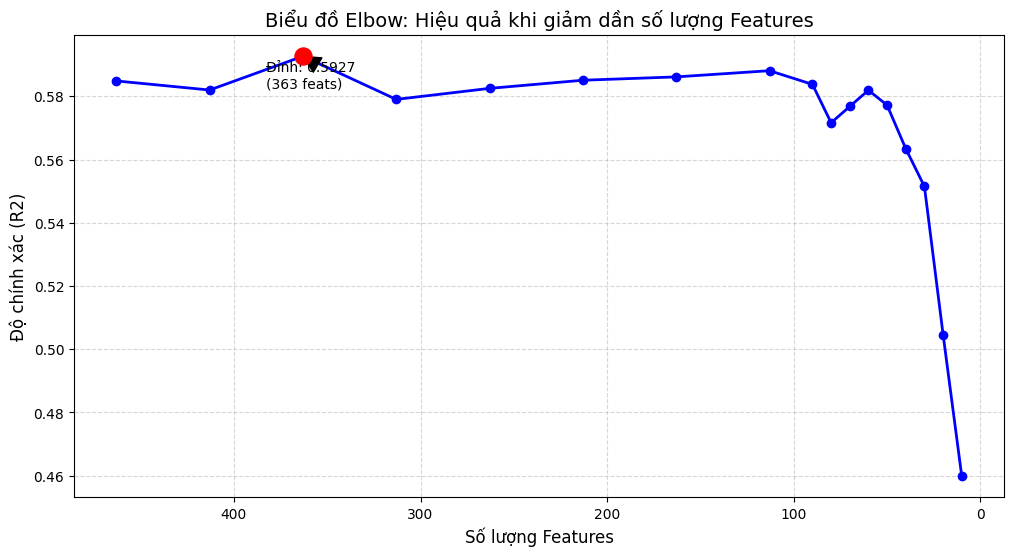


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        RMSE
0  0.592670           363  230.069414
1  0.588095           113  231.357879
2  0.586132           163  231.908357
3  0.585077           213  232.203923
4  0.584854           463  232.266129
5  0.583768            90  232.569708
6  0.582504           263  232.922714
7  0.581981           413  233.068598
8  0.581917            60  233.086224
9  0.579021           313  233.892316

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        RMSE
16            10  0.459846  264.938103
15            20  0.504659  253.710043
14            30  0.551470  241.424523
13            40  0.563439  238.181457
12            50  0.577178  234.403650
11            60  0.581917  233.086224
10            70  0.576790  234.511294
9             80  0.571621  235.938928
8             90  0.583768  232.569708
7            113  0.588095  231.357879


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})


df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'result/feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'RMSE']].head(10))

# Elbow RFECV Model


--- START RFE WITH LEADERBOARD ---
Fitting estimator with 937 features.
Fitting estimator with 917 features.
Fitting estimator with 897 features.
Fitting estimator with 877 features.
Fitting estimator with 857 features.
Fitting estimator with 837 features.
Fitting estimator with 817 features.
Fitting estimator with 797 features.
Fitting estimator with 777 features.
Fitting estimator with 757 features.
Fitting estimator with 737 features.
Fitting estimator with 717 features.
Fitting estimator with 697 features.

Time Run: 752.14 s
Best Number of Features: 677
Best R2 Score: 0.5270

LEADERBOARD (DESCENDING SCORE):
 Num_Features  Score_R2
          690  0.526966
          310  0.526411
          290  0.526232
          510  0.526180
          670  0.526053
          570  0.525978
          490  0.525956
          470  0.525943
          250  0.525854
          590  0.525624

PROGRESS (BY FEATURE COUNT):
 Num_Features  Score_R2
           50  0.488327
           70  0.486406
           90

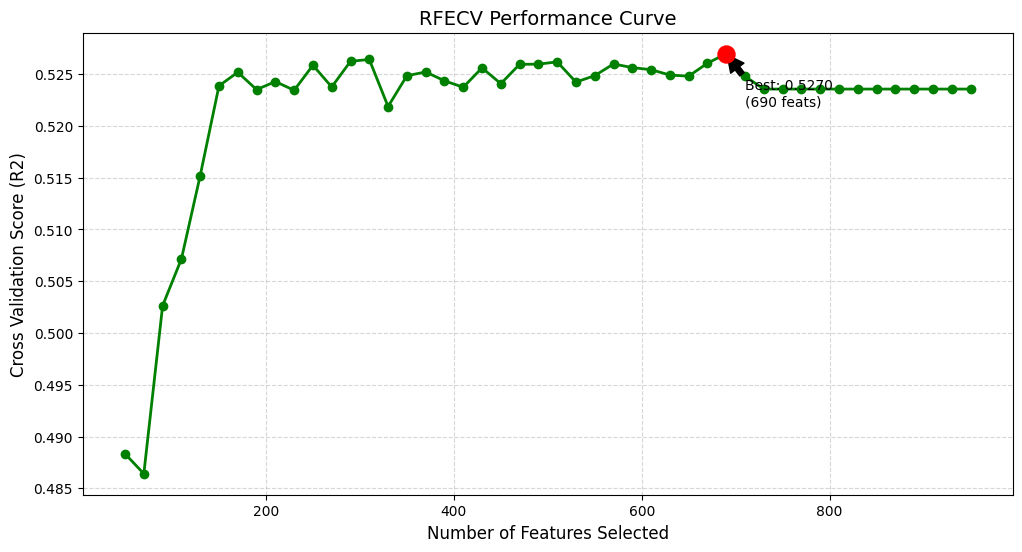


Selected Features List:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA8', 'SlogP_VSA1', 'SlogP_VSA10', '

In [12]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np

print("\n--- START RFE WITH LEADERBOARD ---")
start = time.time()

model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=1,
    verbose=-1
)

rfecv = RFECV(
    estimator=model,
    step=20,
    cv=3,
    scoring='r2', 
    min_features_to_select=50,
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train, y_train)

r2_scores = rfecv.cv_results_['mean_test_score']
n_scores = len(r2_scores)

feature_counts = [50 + i * 20 for i in range(n_scores)]

df_results = pd.DataFrame({
    'Num_Features': feature_counts,
    'Score_R2': r2_scores
})

df_leaderboard = df_results.sort_values(by='Score_R2', ascending=False).reset_index(drop=True)

selected_rfecv = X_train.columns[rfecv.support_]
print(f"\nTime Run: {time.time() - start:.2f} s")
print(f"Best Number of Features: {rfecv.n_features_}")
print(f"Best R2 Score: {df_leaderboard.iloc[0]['Score_R2']:.4f}")

print("\nLEADERBOARD (DESCENDING SCORE):")
print(df_leaderboard.head(10).to_string(index=False))

print("\nPROGRESS (BY FEATURE COUNT):")
print(df_results.head(10).to_string(index=False))

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['Score_R2'], marker='o', color='green', linewidth=2)

best_row = df_leaderboard.iloc[0]
plt.scatter(best_row['Num_Features'], best_row['Score_R2'], color='red', s=150, zorder=5)
plt.annotate(f"Best: {best_row['Score_R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['Score_R2']), 
             xytext=(best_row['Num_Features']+20, best_row['Score_R2']-0.005),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFECV Performance Curve', fontsize=14)
plt.xlabel('Number of Features Selected', fontsize=12)
plt.ylabel('Cross Validation Score (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

print("\nSelected Features List:")
print(list(selected_rfecv))

df_results.to_csv('result/rfecv_results.csv', index=False)

# Compare before and after using partial correlation

Phat hien 6 features tuong quan > 0.999
Vi du: ['Chi1', 'SMR_VSA_sum', 'MolWt', 'ExactMolWt', 'SlogP_VSA_sum']
Train thu tren 931 features...
Ket qua R2 moi: 0.3032


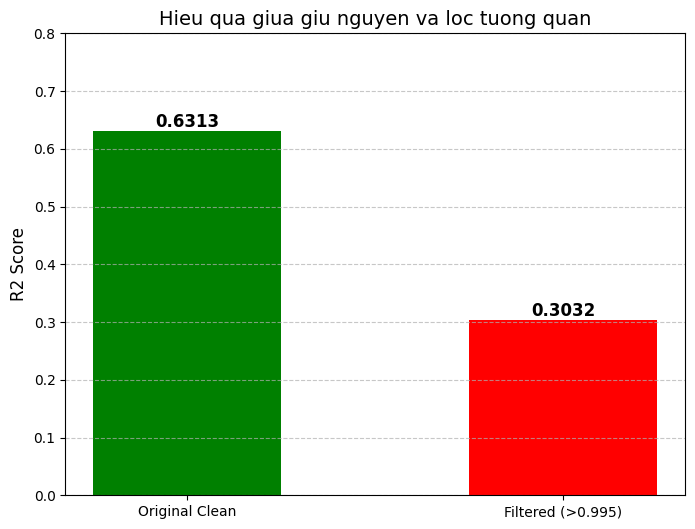

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

ULTRA_HIGH_CORR = 0.999 

corr_matrix = X_train_clean.corr().abs()

ranker_temp = LGBMRegressor(n_estimators=100, verbose=-1, random_state=2601)
ranker_temp.fit(X_train_clean, y_train_clean)
importances = pd.Series(ranker_temp.feature_importances_, index=X_train_clean.columns)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = []

for column in upper.columns:
    correlated_cols = upper.index[upper[column] > ULTRA_HIGH_CORR].tolist()
    if correlated_cols:
        for other_col in correlated_cols:
            if other_col in to_drop: continue
            imp_col = importances.get(column, 0)
            imp_other = importances.get(other_col, 0)
            if imp_col < imp_other:
                to_drop.append(column)
                break 
            else:
                to_drop.append(other_col)

to_drop = list(set(to_drop))

print(f"Phat hien {len(to_drop)} features tuong quan > {ULTRA_HIGH_CORR}")
print(f"Vi du: {to_drop[:5]}")

voting_model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=1,
    verbose=-1
)

if len(to_drop) > 0:
    X_train_ultra = X_train_clean.drop(columns=to_drop)
    X_test_ultra = X_test.drop(columns=to_drop)

    print(f"Train thu tren {X_train_ultra.shape[1]} features...")
    voting_model.fit(X_train_ultra, y_train_clean)
    
    y_pred = voting_model.predict(X_test_ultra)
    new_r2 = r2_score(y_test, y_pred)
    
    old_r2 = 0.6313 
    
    print(f"Ket qua R2 moi: {new_r2:.4f}")
    
    methods = ['Original Clean', 'Filtered (>0.995)']
    scores = [old_r2, new_r2]
    colors = ['green', 'red']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, scores, color=colors, width=0.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Hieu qua giua giu nguyen va loc tuong quan', fontsize=14)
    plt.ylabel('R2 Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.8)
    plt.show()

else:
    print("Khong co features nao qua giong nhau de xoa.")

---

# EXTRA MODEL 
# MAE (Mean Absolute Error)

Ranking features (Fast Mode)...
Ranking done in 4.6s

Starting MAE Loop (26 steps)...
   -> Top 937 features: MAE = 117.83
   -> Top 887 features: MAE = 117.58
   -> Top 837 features: MAE = 117.03
   -> Top 787 features: MAE = 116.94
   -> Top 737 features: MAE = 116.94
   -> Top 687 features: MAE = 117.56
   -> Top 637 features: MAE = 117.36
   -> Top 587 features: MAE = 117.99
   -> Top 537 features: MAE = 117.57
   -> Top 487 features: MAE = 117.61
   -> Top 437 features: MAE = 117.82
   -> Top 387 features: MAE = 116.68
   -> Top 337 features: MAE = 117.38
   -> Top 287 features: MAE = 116.94
   -> Top 237 features: MAE = 118.36
   -> Top 187 features: MAE = 117.97
   -> Top 137 features: MAE = 118.77
   -> Top  90 features: MAE = 120.10
   -> Top  80 features: MAE = 120.71
   -> Top  70 features: MAE = 119.34
   -> Top  60 features: MAE = 120.38
   -> Top  50 features: MAE = 122.74
   -> Top  40 features: MAE = 123.90
   -> Top  30 features: MAE = 126.58
   -> Top  20 features: MA

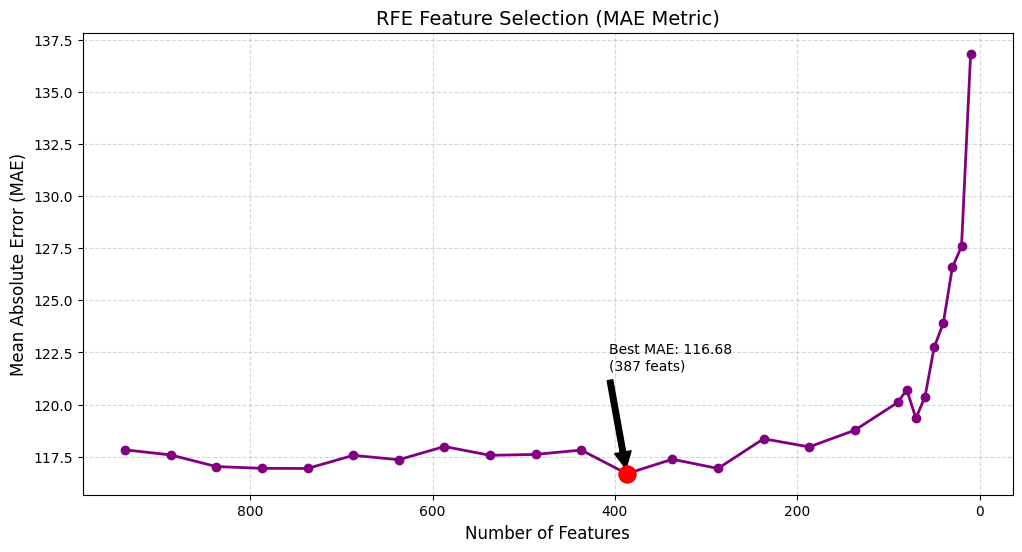


TOP 5 CONFIGURATIONS (LOWEST MAE):
   Num_Features         MAE
0           387  116.683361
1           287  116.935812
2           737  116.935865
3           787  116.942502
4           837  117.026274

LOOP PROGRESS:
    Num_Features         MAE
25            10  136.818751
24            20  127.578197
23            30  126.581186
22            40  123.898395
21            50  122.739235
20            60  120.378479
19            70  119.342256
18            80  120.709770
17            90  120.099173
16           137  118.768704


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
import time

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

fast_params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'num_leaves': 31,
    'random_state': 2601,
    'n_jobs': -1,
    'verbose': -1
}

print("Ranking features (Fast Mode)...")
start_time = time.time()

rfe_selector = RFE(estimator=LGBMRegressor(**fast_params), 
                   n_features_to_select=1, 
                   step=0.1, 
                   verbose=0)

rfe_selector.fit(X_train, y_train) 

rfe_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe_selector.ranking_
}).sort_values(by='Rank', ascending=True)

sorted_feats = rfe_df['Feature'].tolist()
print(f"Ranking done in {time.time() - start_time:.1f}s")

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nStarting MAE Loop ({len(steps)} steps)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])
    mae = mean_absolute_error(y_test, y_pred)

    print(f"   -> Top {k:3d} features: MAE = {mae:.2f}")
    results.append({'Num_Features': k, 'MAE': mae})

df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='MAE', ascending=True).reset_index(drop=True)

csv_filename = 'result/rfe_mae_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['MAE'], marker='o', linewidth=2, color='purple')

best_row = df_results.loc[df_results['MAE'].idxmin()]
plt.scatter(best_row['Num_Features'], best_row['MAE'], color='red', s=150, zorder=5)
plt.annotate(f"Best MAE: {best_row['MAE']:.2f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['MAE']), 
             xytext=(best_row['Num_Features']+20, best_row['MAE']+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFE Feature Selection (MAE Metric)', fontsize=14)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nTOP 5 CONFIGURATIONS (LOWEST MAE):")
print(df_leaderboard.head(5))

print("\nLOOP PROGRESS:")
print(df_results.head(10))